In [1]:
import torch
import torchvision
import numpy as np
import os.path as osp
import os
import time
import pandas as pd

In [2]:
CUDA = torch.cuda.is_available()
CUDA

False

In [3]:
# GLOBALS
# vot_path = "../../../vot2016/"
vot_path = "/home/zabulskyy/Datasets/vot2016/"
yolo_pred_path = "../yolo_predictions/extended"
# yolo_pred_path = "/mnt/sshfs/YOLO-tracker/yolo_predictions/extended"

# coefficents of the parameters for computing energy
crit_vals = {
    "iou": 1,
    "cc": 1,               # class_correspondence
    "id": 1,               # initial dist 
    "vd": 1                # vector dist
}

classes = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['blanket', 'bolt2', 'traffic', 'ball1', 'leaves', 'pedestrian1', 'singer3', 'helicopter', 'godfather', 'soccer1', 'book', 'tunnel', 'gymnastics1', 'basketball', 'birds1', 'car1', 'ball2', 'birds2', 'motocross1', 'bmx', 'gymnastics2', 'fish3', 'motocross2', 'soccer2', 'octopus', 'fernando', 'shaking', 'crossing', 'singer2', 'soldier', 'pedestrian2', 'nature', 'butterfly', 'road', 'iceskater2', 'sphere', 'fish2', 'graduate', 'marching', 'rabbit', 'car2', 'matrix', 'girl', 'tiger', 'gymnastics4', 'wiper', 'racing', 'dinosaur', 'bolt1', 'hand', 'handball1', 'bag', 'sheep', 'iceskater1', 'fish1', 'singer1', 'gymnastics3', 'fish4', 'glove', 'handball2']

print(classes)

dist = torch.nn.modules.PairwiseDistance()

vot_classes = [x for x in os.listdir(vot_path) if not x.endswith(".txt")]

print(vot_classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['blanket', 'bolt2', 'traffic', 'ball1', 'leaves', 'pedestrian1', 'singer3', 'helicopter', 'godfather', 'soccer1', 'book', 'tunnel', '

In [4]:
def read_csv(file):
    with open(file, 'r') as file:
        l = file.read().split("\n")
        l.pop(-1)
        l = [[float(x) for x in y.split(",")[:-1]] for y in l]   
        return torch.tensor(l)
    

In [5]:
cm = read_csv("correlations.csv")  # correlation matrix

In [7]:
p, i = torch.sort(cm[2])
p, i = reversed(p), reversed(i)
table = [[classes[i[k]], float(p[k])] for k in range(len(cm[2]))]
pd.DataFrame(table[:10], columns=["class", "correlation"])

,class,correlation
0,car,1.000000
1,truck,0.231147
2,toaster,0.017915
3,boat,0.001517
4,donut,0.001507
5,mouse,-0.000086
6,bus,-0.000256
7,bowl,-0.000798
8,fork,-0.001966
9,cell phone,-0.002041


In [8]:
def dist2(box1, box2):
    # euclidean distance between two boxes
    x11, y11, x12, y12 = box1[1:5] if len(box1) != 4 else box1[:]
    x21, y21, x22, y22 = box2[1:5] if len(box2) != 4 else box2[:]
    x1, y1 = (x11 + x12) / 2, (y11 + y12) / 2
    x2, y2 = (x21 + x22) / 2, (y21 + y22) / 2
    X = (x1 - x2) ** 2
    Y = (y1 - y2) ** 2
    res = float((X + Y) ** 0.5)
    return res

def the_closest(box_to_compare, boxes):
    # returns the closest box and its index
    m, i = np.infty, 0
    for n, box in enumerate(boxes):
        d = dist2(box, box_to_compare)
        if d < m:
            m = float(d)
            i = n
    return boxes[i], i

In [33]:
def iou(boxA, boxB):
    # IoU between two boxes
    boxA = boxA[1:5] if len(boxA) != 4 else boxA
    boxB = boxB[1:5] if len(boxB) != 4 else boxB

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    res = interArea / float(boxAArea + boxBArea - interArea)
    return res

def the_most_iou(box_to_compare, boxes):
    # returns the box with greatest IoU and its index
    M, i = 0, 0
    for n, box in enumerate(boxes):
        v = iou(box, box_to_compare)
        if v > M:
            M = float(v)
            i = n
    return boxes[i], i

In [10]:
def generate_subframes(row1, row2, width):
    frame1, frame2 = int(row1[0]), int(row2[0])
    diff = frame1 - frame2
    if diff == 1:
        return None
    result = torch.zeros((frame2 - frame1 - 1, width))
    # result[:, -1] = row1[-1]
    step = (row1 - row2) / diff
    for frame_n in range(frame2 - frame1 - 1):
        result[frame_n] = row1 + (step) * (frame_n + 1)
    return result

In [11]:
def merge_frames(*rows):
    result = torch.zeros((1, 8))
    n = len(rows)
    for row in rows:
        result += row
    return result / n

In [12]:
def fill_first(tensor):
    FIRST = tensor[0]
    for i in range(int(FIRST[0]) - 1, -1, -1):
        row = FIRST
        row[0] = i
        row = row.view((1, -1))
        tensor = torch.cat((row, tensor))
    return tensor

In [13]:
def fill_last(tensor, NUM_FRAMES):
    last = tensor[tensor[:, 0] != 0][-1]
    for i in range(int(last[0]) + 1, NUM_FRAMES):
        row = last
        row[0] = i
        row = row.view((1, -1))
        tensor[i] = row
    return tensor

In [14]:
def most_frequent_class(results):
    counts = np.bincount(results[:, -1])
    return np.argmax(counts)

In [15]:
def interpolate(data):
    # TODO: replace with built-in torch functionality
    """
    interpolate gaps
    choose one detection among multiple, by picking the closest one by the euclidean distance
    ignore class labels
    :param OUTPUT: tensor
    :param NUM_FRAMES:
    :param CUDA: bool - if cuda is available
    :return: interpolated tensor
    """
    OUTPUT = data["output"]
    NUM_FRAMES = data["num_frames"]
    CUDA = data["CUDA"]

    width = OUTPUT.size()[1]
    result = torch.zeros((NUM_FRAMES, width))
    if CUDA:
        result = result.cuda()

    if OUTPUT[0][0] != 0:
        OUTPUT = fill_first(OUTPUT)

    output_iter = 0
    res_iter = 0
    while res_iter != NUM_FRAMES:
        if (output_iter > len(OUTPUT) - 1):
            # break
            result = fill_last(result, NUM_FRAMES)
            break
        if output_iter == OUTPUT.shape[0] - 1:
            result[res_iter] = OUTPUT[output_iter]
            output_iter += 1
            res_iter += 1
            continue

        # next frame is interpolated
        if OUTPUT[output_iter][0] == OUTPUT[output_iter + 1][0] - 1:
            result[res_iter] = OUTPUT[output_iter]
            output_iter += 1
            res_iter += 1
            continue

        # missing detection on some frames, fill with missing
        if OUTPUT[output_iter][0] + 1 < OUTPUT[output_iter + 1][0]:
            subframes = generate_subframes(
                OUTPUT[output_iter], OUTPUT[output_iter + 1], width)
            result[res_iter] = OUTPUT[output_iter]
            for subframe in subframes:
                res_iter += 1
                result[res_iter] = subframe
            output_iter += 1
            res_iter += 1
            continue

        # this frame contains multiple detections, have to choose one
        if OUTPUT[output_iter][0] == OUTPUT[output_iter + 1][0]:
            frame = OUTPUT[output_iter][0]
            to_cut = OUTPUT[OUTPUT[:, 0] == frame]
            closest, _ = the_most_iou(result[res_iter - 1], to_cut)
            result[res_iter] = closest

            output_iter += len(to_cut)
            res_iter += 1

            if output_iter >= OUTPUT.shape[0] - 1:
                break

            # missing detection on some frames, fill with missing
            if OUTPUT[output_iter - 1][0] + 1 < OUTPUT[output_iter][0]:
                subframes = generate_subframes(
                    result[res_iter - 1], OUTPUT[output_iter], width)
                for subframe in subframes:
                    result[res_iter] = subframe
                    res_iter += 1
            continue
    return result

In [16]:
def read_gt(vot_class, vot_path=vot_path, force_square=True):
    # read the groundtruth for a precise vot class
    gt_file = osp.join(vot_path, vot_class, "groundtruth.txt")
    with open(gt_file, 'r') as file:
        l =file.read().split("\n")
        l.pop(-1)
        l = [[float(x) for x in y.split(",")] for y in l]
        if force_square:
            l = [[min(m[::2]), min(m[1::2]), max(m[::2]), max(m[1::2])] for m in l]   
        return torch.tensor(l)
    
def read_full_gt(vot_path=vot_path, force_square=True):
    # read the groundtruth for a full vot dataset
    vot_classes = [x for x in os.listdir(vot_path) if not x.endswith(".txt")]
    X = list()
    for vot_class in vot_classes:
        gt_file = osp.join(vot_path, vot_class, "groundtruth.txt")
        with open(gt_file, 'r') as file:
            l =file.read().split("\n")
            l.pop(-1)
            l = [[float(x) for x in y.split(",")] for y in l]
            if force_square:
                l = [[min(m[::2]), min(m[1::2]), max(m[::2]), max(m[1::2])] for m in l]   
        X.append(l)
    return torch.tensor(X)

In [17]:
def read_yolo_pred(vot_class, yolo_pred_path=yolo_pred_path, pred_format="csv", first_len=True):
    # read offline-made YOLO predictions for a single vot class
    yolo_pred_file = osp.join(yolo_pred_path, vot_class + "." + pred_format)
    with open(yolo_pred_file, 'r') as file:
        l =file.read().split("\n")
        l.pop(-1)
        im_len = -1
        if first_len:
            im_len = float(l.pop(0))
        l = [[float(x) for x in y.split(",")] for y in l]            
        return torch.tensor(l), im_len
    

In [18]:
# read all YOLO predictions
yolo_pred = dict()

for i in vot_classes:
    print(i, end=" ")
    yolo_pred[i] = read_yolo_pred(i)
    

blanket bolt2 traffic ball1 leaves pedestrian1 singer3 helicopter godfather soccer1 book tunnel gymnastics1 basketball birds1 car1 ball2 birds2 motocross1 bmx gymnastics2 fish3 motocross2 soccer2 octopus fernando shaking crossing singer2 soldier pedestrian2 nature butterfly road iceskater2 sphere fish2 graduate marching rabbit car2 matrix girl tiger gymnastics4 wiper racing dinosaur bolt1 hand handball1 bag sheep iceskater1 fish1 singer1 gymnastics3 fish4 glove handball2 

In [19]:
# functional to the offline-calculating of the class correlations

# compute class correlation
def ccc(classes_probs):
    # classes_probs.shape = (bboxes, classes)
    corr_mat = torch.zeros((classes_probs.shape[1], classes_probs.shape[1], ))

    for cls in range(len(classes_probs[0])):
        col = classes_probs[:, cls].view((-1, 1))
        tX = col * classes_probs
        sX = torch.sum(tX, dim=0)
        corr_mat[cls] = sX
    return corr_mat

def corr(col1, col2):
    mean1, mean2 = torch.mean(col1), torch.mean(col2)
    cm1, cm2 = col1 - mean1, col2 - mean2
    top = sum(cm1 * cm2)
    bot = torch.sqrt(sum(cm1 ** 2) * sum(cm2 ** 2))
    return top / bot

# compute class correlation coefficient
def cccc(classes_probs):
    # classes_probs.shape = (bboxes, classes)
    corr_mat = torch.zeros((classes_probs.shape[1], classes_probs.shape[1], ))
    num_classes = len(classes_probs[0])
    for cls1 in range(num_classes):
        col1 = classes_probs[:, cls1].view((-1, 1))
        for cls2 in range(cls1 + 1, num_classes):
            print("{}.{} / {}".format(cls1+1, cls2+1, num_classes))
            col2 = classes_probs[:, cls2].view((-1, 1))
            _corr = corr(col1, col2)
#             _corr = np.corrcoef(col1, col2)
            corr_mat[cls1, cls2] = _corr
    return corr_mat

In [20]:
# read all yolo predictions and store in a single tensor
def read_all_yolo_preds(path=yolo_pred_path, pred_format="csv"):
    X = []
    for vot_class in os.listdir(path):
        yolo_pred_file = osp.join(path, vot_class)
        with open(yolo_pred_file, 'r') as file:
            l = file.read().split("\n")
            l.pop(-1)
            l.pop(0)
            im_len = -1
            for i in l:
                X.append([float(x) for x in i.split(",")])
    X = torch.tensor(X)
    return X

In [21]:
def eval_single_class_corr(cls1 : int, cls2 : int, correlations=cm):
    # calculate correlations between two classes
    return float(cm[cls1][cls2])

def eval_whole_class_corr(cls1, cls2, correlations=cm):
    # TODO: consider if this worth it
    # too complicated yet
    pass

In [22]:
def normalise(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    return (tensor - mean) / std

In [23]:
def write_csv(matrix, file="correlations.csv"):
    for i in matrix.tolist():
        for j in i:
            print(j, sep=", ", end=", ", file=open(file, "a+"))
        print(file=open(file, "a+"))

In [24]:
def eval_energy(bb1, bb2, cv=crit_vals, ban_negative_cc=True):
    box1, box2 = bb1[1:5], bb2[1:5]
    cls1, cls2 = bb1[6: ], bb2[6: ]  # 5'th column is the precision of the bbox
    class1, class2 = torch.argmax(cls1), torch.argmax(cls2)
    
    _iou = iou(box1, box2)
    _cc = eval_single_class_corr(class1, class2)
    _vd = vec_dist(bb1, bb2)
    
    return {"iou": _iou, "cc": _cc, "vd": 1 / _vd}

In [25]:
def cebtf(frame1, frame2, cv=crit_vals, ban_negative_cc=True):  
    # calculate_energies_between_two_frames
    _boxes = torch.zeros((len(frame1)))
    _energies = torch.zeros((len(frame1)))
    for i in range(len(frame1)):
        max_energy = 0
        max_energy_index = 0
        
        ious = torch.zeros(len(frame2))
        ccs = torch.zeros(len(frame2))
        vds = torch.zeros(len(frame2))
        
        for j in range(len(frame2)):
            energy = eval_energy(frame1[i], frame2[j], cv=crit_vals, ban_negative_cc=ban_negative_cc)
            
            if ban_negative_cc and energy["cc"] < 0:        
                pass  # values are already 0
            else:          
                ious[j] = energy["iou"] * crit_vals["iou"]
                ccs[j] = energy["cc"] * crit_vals["cc"]
                vds[j] = energy["vd"] * crit_vals["vd"]
                
        # normalize
        ious = ious / (torch.max(ious) + 1e-10)
        ccs = ccs / (torch.max(ccs) + 1e-10)
        vds = vds / (torch.max(vds) + 1e-10)
        
        energies = sum((ious, ccs, vds))

        _boxes[i] = torch.argmax(energies)
        _energies[i] = torch.max(energies)
    return _boxes, _energies
          

In [26]:
def pp_first(data):
    # detects the closest object to FIRST gt box and removes the rest on the FIRST frame
    CUDA = data["CUDA"]
    output = data["output"]
    first = data["first"]

    tcc, _ = the_most_iou(first, output[:, 1:5])
    
    # only detections close to the true FIRST frame    
    output = replace_first_frame(tcc, output)
    return output

def replace_first_frame(to_replace, OUTPUT):
    to_replace = to_replace[:4]
    OUTPUT = OUTPUT[OUTPUT[:, 0] != 0]
    to_replace = to_replace.view((1, -1))
    _to_replace = torch.zeros((1, 8))
    _to_replace[0][1:5] = to_replace[0]
    return torch.cat((_to_replace, OUTPUT))

In [27]:
def get_first(vot_class):
    with open(osp.join(vot_path, vot_class, "groundtruth.txt"), 'r') as file:
        l = [float(x) for x in file.read().split("\n")[0].split(",")]
        X, Y = l[::2], l[1::2]
        l = [min(X), min(Y), max(X), max(Y)]
        l = torch.tensor([float(x) for x in l])
        return l

In [28]:
def initial_energy(first_boxes, method="ltd2", cv=crit_vals, ): 
    l = first_boxes.shape[0]
    ies = torch.zeros(l)  # initial_energies
    for i in range(l):
        for j in range(l):
            ie = dist2(first_boxes[i],first_boxes[j])
            ies[i] += ie
    ies = 1 / ies * crit_vals["id"]
    return ies
            

In [29]:
def vec_dist(vec1, vec2, dist=dist):
    
    vd = None
    
    if len(vec1) > 80:
        vec1[torch.argmax(vec1[6:]) + 6] = 1
        vec2[torch.argmax(vec2[6:]) + 6] = 1
        vd = dist(vec1[6:].view([1, -1]), vec2[6:].view([1, -1]))
    else:
        vec1[torch.argmax(vec1)] = 1
        vec2[torch.argmax(vec2)] = 1
        vd = dist(vec1.view([1, -1]), vec2.view([1, -1])) 
    return vd

def the_closest_vec(row_to_compare, rows):
    m, i = np.infty, 0
    for n, row in enumerate(rows):
        d = vec_dist(row, row_to_compare)
        if d < m:
            m = float(d)
            i = n
    return rows[i], i
    

In [35]:
def do_dp(vot_class, total_res, cv=crit_vals):
    # do dynamic programming
    # core function 
    yp, imlen = yolo_pred[vot_class]  # yolo predictions
    imlen = int(imlen)
    
    data = dict()
    data["output"] = yp
    data["num_frames"] = int(imlen)
    data["CUDA"] = CUDA
    data["first"] = get_first(vot_class)
    
    if CUDA:
        data["output"] = data["output"].cuda()
        data["first"] = data["first"].cuda()
    
    frames_with_detection = sorted(list(set(data["output"][:,0].tolist())))
    ffwdi = frames_with_detection[0]  # first_frame_with_detection_index
    first_boxes = data["output"][data["output"][:, 0] == ffwdi]
    path = torch.zeros((len(first_boxes), imlen))
    energies = torch.zeros((len(first_boxes), imlen))
    
    prev_boxes = first_boxes
    path[:, 0] = first_boxes[0][0]
    
    
    # calculate energies
    for n, i in enumerate(frames_with_detection[:]):
        i_boxes = data["output"][data["output"][:, 0] == i]
        
        boxes, energy = cebtf(prev_boxes, i_boxes, cv=cv)
        
        path[:, int(n)] = boxes
        energies[:, int(n)] += energy
        
        prev_boxes = i_boxes[boxes.long()]
        
    verdict = torch.sum(energies, dim=1)
    
    # init energies   
    ie = initial_energy(first_boxes, method="ltd2")
    ie = ie / max(ie) * max(verdict) * crit_vals["id"]
    
    if verdict.shape != torch.Size([1]):
        verdict += ie
        
    first_bb_candidates = (verdict == torch.max(verdict)).nonzero().view(-1).tolist()
    res_i = path[first_bb_candidates].view(-1).int()
    res = torch.zeros((len(frames_with_detection), 5))

    # prepare for interpolation
    for n, i in enumerate(frames_with_detection[:]):
        cfp = data["output"][data["output"][:, 0] == i]  # current_frame_predictions
        index = res_i[n]
        cp = cfp[index] # chosen_prediction
        res[int(n)] = cp[:5]

    total_res[vot_class] = interpolate(data)[:, 1:5].tolist()
    
    return total_res
    

In [36]:
total_res=dict()

In [38]:
def save(res, folder, ext="csv", nm_fr=None):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for name in res:
        if nm_fr is not None:
            print(nm_fr[name], file=open(osp.join(folder, name + "." + ext), 'w+'))
            print("\n".join([",".join([str(a) for a in x]) for x in res[name]]),
                  file=open(osp.join(folder, name + "." + ext), 'a'))
        else:
            print("\n".join([",".join([str(a) for a in x]) for x in res[name]]),
                  file=open(osp.join(folder, name + "." + ext), 'w+'))


In [39]:
def iou(cords1, cords2):
    if len(cords2) < 4:
        if (cords2[0] == 1):
            return 1
        return 1
    if (len(cords1) == 8):
        X1, Y1 = cords1[::2], cords1[1::2]
        cords1 = [min(X1), min(Y1), max(X1),  max(Y1)]
    if (len(cords2) == 8):
        X2, Y2 = cords2[::2], cords2[1::2]
        cords2 = [min(X2), min(Y2), max(X2),  max(Y2)]
    xA = max(cords1[0], cords2[0])
    yA = max(cords1[1], cords2[1])
    xB = min(cords1[2], cords2[2])
    yB = min(cords1[3], cords2[3])
    interArea = max(0, xB - xA + 1e-32) * max(0, yB - yA + 1e-32)
    cords1Area = (cords1[2] - cords1[0] + 1e-32) * \
        (cords1[3] - cords1[1] + 1e-32)
    cords2Area = (cords2[2] - cords2[0] + 1e-32) * \
        (cords2[3] - cords2[1] + 1e-32)
    return interArea / float(cords1Area + cords2Area - interArea)

In [40]:
def open_and_cast(file):
    with open(file, 'r') as f:
        pred = [s.split(',') for s in f.read().split("\n")]
        for i in range(len(pred)):
            if pred[i] == [""]:
                pred.pop(i)
                continue
            pred[i] = [float(x) for x in pred[i]]
    return pred

In [41]:
def grade(gt_path, pred_path, method="mean_iou"):
    gt = open_and_cast(gt_path)
    pred = open_and_cast(pred_path)
    grades = [iou(gt[i], pred[i]) for i in range(len(gt))]
    return sum(grades) / len(grades), grades

In [42]:
def grade_vot(vot_folder, res_folder, gt_filename="groundtruth.txt", ext=".csv"):
    vot_folders = sorted(os.listdir(vot_folder))
    res = dict()
    for i in range(len(vot_folders)):
        if (vot_folders[i].endswith(".txt")):
            continue
        gt_file = osp.join(vot_folder, vot_folders[i], gt_filename)
        pred_file = osp.join(res_folder, vot_folders[i] + ext)

        single_grade = grade(gt_file, pred_file)[0]
        res[vot_folders[i]] = single_grade
    mean = 0
    for i in res:
        mean += res[i]
    mean /= len(res.keys())
    return mean, res

In [43]:
def grade_vot_first_bb(vot_folder, res_folder, gt_filename="groundtruth.txt", ext=".csv"):
    # evaluate prediction of the first box
    vot_folders = sorted(os.listdir(vot_folder))
    res = dict()
    for i in range(len(vot_folders)):
        if (vot_folders[i].endswith(".txt")):
            continue
        gt_file = osp.join(vot_folder, vot_folders[i], gt_filename)
        pred_file = osp.join(res_folder, vot_folders[i] + ext)

        gt_file = osp.join(vot_folder, vot_folders[i], gt_filename)
        pred_file = osp.join(res_folder, vot_folders[i] + ext)
        
        gt = open_and_cast(gt_file)
        pred = open_and_cast(pred_file)
        grade = iou(gt[0], pred[0])
        res[vot_folders[i]] = grade
    mean = 0
    for i in res:
        mean += res[i]
    mean /= len(res.keys())
    return mean, res

In [44]:
# testing different parameters
params = list()
for i in range(0, 4):
    for j in range(0, 4):
        for k in range(0, 4):
            if not (k == j == i):
                params.append((i,j,k))
                

In [45]:
crit_vals = {
    "iou": 1,
    "cc": 1,               # class_correspondence
    "id": 1e-10,           # initial dist - keep for later experiments
    "vd": 1                # vector dist
}

In [46]:
# for param in params:  # testing on different parameters
for param in [(1,1,1)]:  # testing on equal parameters
    total_res = dict()
    crit_vals["cc"], crit_vals["iou"], crit_vals["vd"] = param
    dirname = osp.join("param_tests", '_'.join(['%s%s' % (key, value) for (key, value) in crit_vals.items()]))
    
    print(crit_vals)
    start = time.time()
    
    for n, vot_class in enumerate(sorted([x for x in os.listdir(vot_path) if not x.endswith(".txt")])):
        
        print(vot_class, end=" ")
        do_dp(vot_class, total_res)
        
    save(total_res, dirname)
    a = grade_vot(vot_path, dirname)  
    print(a, file = open(dirname + ".txt", "w+"))
    print("accur.: ", a[0])
    done = time.time()
    elapsed = done - start
    print(elapsed)
    print()    
    

In [48]:
grade_vot(vot_path, "./descriptors")

(0.23479305581203105,
 {'bag': 0.4583195794231945,
  'ball1': 0.0,
  'ball2': 0.0,
  'basketball': 0.44687203526381475,
  'birds1': 0.37207317042938814,
  'birds2': 0.4456295906663306,
  'blanket': 0.0,
  'bmx': 0.6186096982355661,
  'bolt1': 0.31317189839217663,
  'bolt2': 0.5559316924194491,
  'book': 0.14127091889444326,
  'butterfly': 0.12169475910666508,
  'car1': 0.5353646999573198,
  'car2': 0.06258817172097283,
  'crossing': 0.5233986348040006,
  'dinosaur': 0.13894772393413063,
  'fernando': 0.5234114742238225,
  'fish1': 0.0100746068440364,
  'fish2': 0.029448131178084723,
  'fish3': 0.40884582357120064,
  'fish4': 0.04274290183126452,
  'girl': 0.3987842530466955,
  'glove': 0.033467150206793174,
  'godfather': 0.03731887368450053,
  'graduate': 0.2713302108988427,
  'gymnastics1': 0.3049746340775712,
  'gymnastics2': 0.09629783113421757,
  'gymnastics3': 0.027579656627007183,
  'gymnastics4': 0.0,
  'hand': 0.07730948541736773,
  'handball1': 0.0,
  'handball2': 0.007720809

In [49]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path as osp
import argparse
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from random import randrange
import numpy as np
from matplotlib.pyplot import figure

In [53]:
def plot_single_arr(im_path, pr_arr=None, pr_idx=0, gt_arr=None, gt_idx=0, force_square=False):
    im = Image.open(im_path)
    plt.imshow(im)

    if pr_arr is not None:
        l = pr_arr[pr_idx]
        if l == "":
            return
        pr_bb = [float(x) for x in l.split(',')]
        if len(pr_bb) < 4:
            return
        if force_square:
            X, Y = pr_bb[::2], pr_bb[1::2]
            pr_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
        elif (len(pr_bb) == 8):
            plt.plot(pr_bb[::2] + [pr_bb[0]],
                     pr_bb[1::2] + [pr_bb[1]], 'r-', lw=2)
        else:
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

    if gt_arr is not None:
        l = gt_arr[gt_idx]
        if l == "":
            return
        gt_bb = [float(x) for x in l.split(',')]

        if (force_square):
            X, Y = gt_bb[::2], gt_bb[1::2]
            gt_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)
        elif (len(gt_bb) == 8):
            plt.plot(gt_bb[::2] + [gt_bb[0]],
                     gt_bb[1::2] + [gt_bb[1]], 'b-', lw=2)
        else:
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)


def plot_single(im_path, pr_path=None, pr_idx=0, gt_path=None, gt_idx=0, force_square=False):
    """
    coords: [x1, y1, x2, y2, x3, y3, x4, y4]
    """

    im = Image.open(im_path)
    plt.imshow(im)

    if pr_path is not None:
        with open(pr_path, 'r') as f:
            l = f.read().split("\n")[pr_idx]
            if l == "":
                return
            pr_bb = [float(x) for x in l.split(',')]

        if (force_square):
            X, Y = pr_bb[::2], pr_bb[1::2]
            pr_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
        elif (len(pr_bb) == 8):
            plt.plot(pr_bb[::2] + [pr_bb[0]],
                     pr_bb[1::2] + [pr_bb[1]], 'r-', lw=2)
        else:
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                     [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

    if gt_path is not None:
        with open(gt_path, 'r') as f:
            l = f.read().split("\n")[gt_idx]
            gt_bb = [float(x) for x in l.split(',')]

        if (force_square):
            X, Y = gt_bb[::2], gt_bb[1::2]
            gt_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)
        elif (len(gt_bb) == 8):
            plt.plot(gt_bb[::2] + [gt_bb[0]],
                     gt_bb[1::2] + [gt_bb[1]], 'b-', lw=2)
        else:
            plt.plot([gt_bb[0], gt_bb[2], gt_bb[2], gt_bb[0], gt_bb[0], ],
                     [gt_bb[1], gt_bb[1], gt_bb[3], gt_bb[3], gt_bb[1], ], 'b-', lw=2)


def save_plot_single_arr(im_path, name="plot.jpg", pr_arr=None, pr_idx=0, gt_arr=None, gt_idx=0, force_square=False):
    plot_single_arr(im_path, pr_arr, pr_idx, gt_arr, gt_idx, force_square)
    plt.show()
    # plt.savefig(name)


def save_plot_single(im_path, name="plot.jpg", pr_path=None, pr_idx=0, gt_path=None, gt_idx=0, force_square=False):
    plot_single(im_path, pr_path, pr_idx, gt_path, gt_idx, force_square)
    plt.savefig(name)


def save_plot_folder(dir_path, saveto="results", pr_path=None, gt_path=None, force_square=False):
    if (not os.path.exists(saveto)):
        os.makedirs(saveto)
    files = sorted([x for x in os.listdir(dir_path) if x.endswith(".jpg")])

    if gt_path is not None:
        with open(gt_path, 'r') as f:
            gt_arr = f.read().split("\n")

    if pr_path is not None:
        with open(pr_path, 'r') as f:
            pr_arr = f.read().split("\n")

    for n, file in enumerate(files):
        name = osp.join(saveto, file)
#         print("saving {}".format(name))
        save_plot_single_arr(osp.join(dir_path, file), name=name, pr_arr=pr_arr,
                             pr_idx=n, gt_arr=gt_arr, gt_idx=n, force_square=force_square)
        plt.close()


def csv2tensor(path_to_file, first_len=False):
    with open(path_to_file, 'r') as f:
        pr_arr = f.read().split("\n")
        if first_len:
            im_len = int(pr_arr.pop(0))
        else:
            im_len = -1
        pr_arr.pop(-1)
        pr_arr = [[float(y) for y in x.split(",")] for x in pr_arr]
        return torch.tensor(pr_arr), im_len


def plot_single_yolo(im_path, pr_arr, pr_idx, gt_arr, gt_idx, force_square, gs=False):
    im = np.array(Image.open(im_path), dtype=np.uint8)
    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)
    # Create a Rectangle patch
    for row in pr_arr[pr_arr[:, 0] == pr_idx]:
        color = (randrange(1, 99) / 100, randrange(1, 99) /
                 100, randrange(1, 99) / 100) if gs == False else (.7, .7, .7)
        label = " " #classes[int(row[-1])]
        x, y = float(row[1]), float(row[2])
        h, w = float(row[4]) - y, float(row[3]) - x
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor=color, facecolor='none', label=label)
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.annotate(label, (x, y), color=color, weight='bold',
                    fontsize=10, ha='left', va='top')
    # plt.show()


def save_plot_single_yolo(im_path, name="plot.jpg", pr_tensor=None, pr_idx=0, gt_tensor=None, gt_idx=0, force_square=False, gs=False):
    plot_single_yolo(im_path, pr_tensor, pr_idx,
                     gt_tensor, gt_idx, force_square, gs)
    # plt.savefig(name)


def plot_everything(save=False, imgs_folder=None, yolo_pred_file=None, pred_file=None, gt_file=None, saveto="results", force_square=False):
    plt.figure(figsize=(60, 80))
    
    if (not os.path.exists(saveto)):
        os.makedirs(saveto)
    files = sorted([x for x in os.listdir(imgs_folder) if x.endswith(".jpg")])

    if gt_file is not None:
        gt_tensor, gt_len = csv2tensor(gt_file)

    if pred_file is not None:
        pred_tensor, pred_len = csv2tensor(pred_file)

    if pred_file is not None:
        yolo_pred_tensor, yolo_pred_len = csv2tensor(yolo_pred_file, True)

    for n, file in enumerate(files):
        name = osp.join(saveto, file)
#         print("saving {}".format(name))
        impath = osp.join(imgs_folder, file)

        plot_single_yolo(impath, yolo_pred_tensor, n,
                         gt_tensor, n, force_square, gs=True)
        plot_single(impath, pred_file, n, gt_file, n, force_square=True)
        if save:
            plt.savefig(name)
        plt.show()
        plt.close()
        

In [54]:
%matplotlib inline

<Figure size 4320x5760 with 0 Axes>

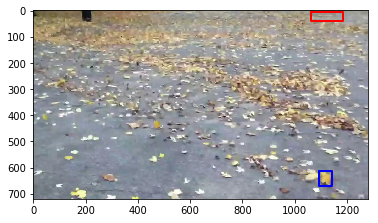

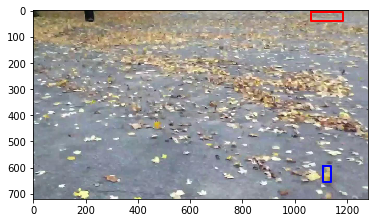

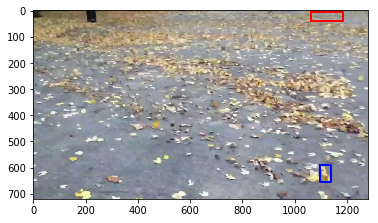

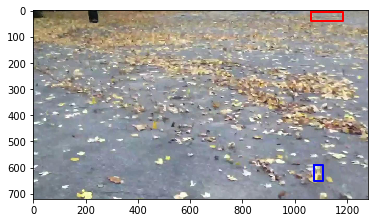

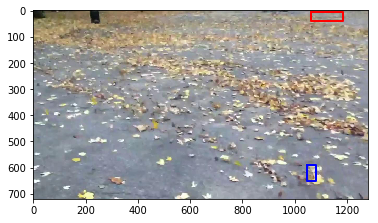

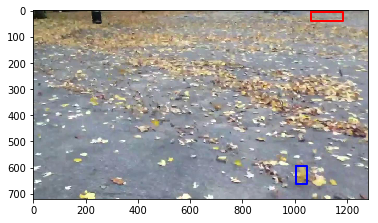

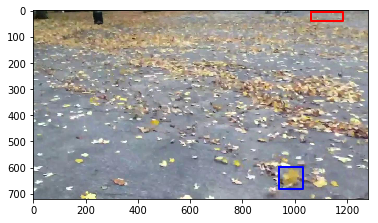

KeyboardInterrupt: 

In [55]:
# save_plot_single("/home/zabulskyy/Datasets/vot2016/leaves/00000100.jpg",
#                  pr_path="/home/zabulskyy/Projects/CTU-Research/results/yolo-blind/leaves.txt",
#                  gt_path="/home/zabulskyy/Datasets/vot2016/leaves/groundtruth.txt",
#                  force_square=True, gt_idx=101, pr_idx=101)
cls = "leaves"
met = "descriptors/"
yolo_pred = "../yolo_predictions/extended/"

# save_plot_folder(osp.join("/home/zabulskyy/Datasets/vot2016", cls), saveto=osp.join("plots", met, cls),
#                  pr_path=osp.join("notebooks/" + met, cls) + ".csv",
#                  gt_path=osp.join(
#                      "/home/zabulskyy/Datasets/vot2016", cls, "groundtruth.txt"),
#                  force_square=True)

plot_everything(imgs_folder=osp.join("/home/zabulskyy/Datasets/vot2016", cls), yolo_pred_file=osp.join(yolo_pred, cls+".csv"),
                    pred_file=osp.join("./" + met, cls) + ".csv", saveto="lololo",
                    force_square=True, gt_file=osp.join(
                     "/home/zabulskyy/Datasets/vot2016", cls, "groundtruth.txt"))


# save_plot_folder("/home/zabulskyy/Datasets/vot2016/leaves", saveto="./plots/yolo-first-smart-smart/leaves",
#                 pr_path="./results/yolo-first-smart-smart/leaves.txt",
#                 gt_path="/home/zabulskyy/Datasets/vot2016/leaves/groundtruth.txt",
#                 force_square=True)